# Python for Fantasy Football - Addressing Class Imbalance Part 2
Welcome to part 7 of my 'Python for Fantasy Football' series! __[Part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__ outlined some strategies for dealing with imbalanced datasets. Since publishing that article I've been diving into the topic further, and I think it's worth writing a follow-up before we move on. One of the comments from __[part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__ was as follows:

<img src="http://www.fantasyfutopia.com/wp-content/uploads/2019/02/comment.png" />

I was surprised by this as well, but at the time I didn't think much of it, as I had heard that SMOTE re-sampling was often the go-to solution for dealing with class imbalance. However, we really should try to understand exactly what is going on here before we start celebrating!

If you haven't worked through the previous articles/Jupyter notebooks or you need a refresher, the links are below (machine learning starts at part 5):

__[Part 1](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__
, __[Part 2](http://www.fantasyfutopia.com/python-for-fantasy-football-matchup-adjustment/)__, __[Part 3](http://www.fantasyfutopia.com/python-for-fantasy-football-getting-and-cleaning-data/)__, __[Part 4](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/)__, __[Part 5](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction/)__, __[Part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__

**Note: part 6 and 7 actually got a lot more technical than I'm comfortable with given that this is supposed to be an introductory series! I highly recommend working through the tutorials on __[Kaggle](https://www.kaggle.com/learn/overview)__ first before you carry on here. The last thing I want is for you to get put off machine learning just because I chose a much trickier example than I should have!**

Before we get going I also wanted to thank everyone again for the great feedback I've been getting! Whilst most of it has been very positive, there have been a couple of comments that the articles are a bit too technical or difficult to understand. If you do feel that way there are plenty of other courses out there, so please give them a try before throwing in the towel! __[Kaggle Learn](https://www.kaggle.com/learn/overview)__ is a great introductory resource, and I highly recommend parts 1-7 of the '__[Introduction to Machine Learning for Coders](http://course18.fast.ai/ml)__' from __[fast.ai](http://course18.fast.ai/ml)__ if you want something more in-depth.

## Using a re-sampled test set is cheating!
In __[part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__ we re-sampled the entire dataset before using cross-validation to test our model. However, there are a couple of big problems with this:

-  Our test set is no longer representative of the problem. Imagine we wanted to put this model into production and see how it performs on data from new matches that it hadn't seen before. The new data would still be imbalanced! We would have trained and tested a model on balanced data, so it's likely that the model wouldn't generalise well to the new imbalanced data. It's essential that we create our test set before re-sampling; in other words, we will only re-sample the training data, not the test data. That way, we will get a much better idea of how the model will perform in practice.
-  There is another reason to only make changes to the training set when using re-sampling techniques. We know from __[part 6](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__ that SMOTE creates new data points by interpolating between existing ones. We likely had many examples in our training set that were nearly identical to synthetic examples in the test set. It's not at all surprising that our previous model performed really well with synthetic data in the test set! If we had used a naive approach of just duplicating existing data this would be even worse, as we could easily have identical observations in both the training and test sets.

To rectify this problem, we have two options:

-  Call train/test split before fitting SMOTE-NC on X_train and y_train only, using X_test and y_test to see how the model performs.
-  Define a custom cross-validation function that re-samples our training data inside each fold, leaving the test data untouched each time.

After reading this article, you will know how to do both. The first one is easy to implement in sklearn; all we need to do is set 'stratify=labels' inside train/test split. We know that our original dataset contains roughly a 9:1 ratio of 'no goal' to 'goal' examples. A stratified split will ensure that those class ratios are maintained when splitting into a training and test set. To save time I skipped the imports and data pre-processing steps here, but if you are following along in notebook form you will see those first.

In [1]:
# Reloads modules automatically in case there are any changes
# See https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%reload_ext autoreload
%autoreload 2

# Show plots without having to call .show()
%matplotlib inline

In [2]:
# You might need to install some of these!
import pandas as pd
import numpy as np
from IPython.display import display
from collections import OrderedDict, Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing, model_selection, metrics
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef, brier_score_loss, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.metrics import *
from sklearn.datasets import load_breast_cancer
from imblearn.datasets import make_imbalance
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

# Hide warnings (always delete this if you are writing/checking your own code)
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the data from csv to avoid extra preprocessing steps and make it easier to compare models
np_shots = pd.read_csv('np_shots.csv')

features = np_shots.drop('goal', axis=1)
labels = np_shots['goal']

# Encode categorical features
cat_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected', 'assisted']

cat_features = features[cat_cols]
features = features.drop(cat_cols, axis=1)

# Use label encoding to convert categorical features to numeric
le = preprocessing.LabelEncoder()
cat_features = cat_features.apply(le.fit_transform)

# Merge with numeric features
features = features.merge(cat_features, left_index=True, right_index=True)

In [4]:
# Nice function to view an example of the data with all columns shown (in case you have lots of them!)
# To do this, the columns are transposed into rows instead
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df.head().transpose())
            
display_all(features)

,0,1,2,3,4
distance,36.400549,9.433981,21.954498,13.601471,16.763055
angle,15.945396,57.994617,59.931417,17.102729,17.354025
duration,0.069232,0.914970,2.955827,0.322000,0.515100
play_pattern,8.000000,0.000000,3.000000,8.000000,2.000000
under_pressure,0.000000,0.000000,0.000000,0.000000,0.000000
body_part,0.000000,1.000000,0.000000,0.000000,0.000000
technique,4.000000,4.000000,4.000000,4.000000,4.000000
first_time,0.000000,0.000000,0.000000,0.000000,0.000000
follows_dribble,0.000000,0.000000,0.000000,0.000000,0.000000
redirect,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
# Split off a test set that is representative of our overall dataset using 'stratify'
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, 
                                                    shuffle=True, stratify=labels, random_state=42)

# Show the class distribution in each label set
def get_class_dist(data, name):
    unique, counts = np.unique(data, return_counts=True)
    pct = 100*(counts/len(data))
    d = dict(zip(unique, zip(counts, pct)))
    print(len(data), 'total examples in %s' % name)
    for key, values in d.items():
        print('class %d: %d examples,' % (key, values[0]), "{0:.2f}%".format(values[1]))
    print('')
    return

get_class_dist(data=y_train, name='y_train')
get_class_dist(data=y_test, name='y_test')

2032 total examples in y_train
class 0: 1836 examples, 90.35%
class 1: 196 examples, 9.65%

508 total examples in y_test
class 0: 459 examples, 90.35%
class 1: 49 examples, 9.65%



Looks like it worked! We can now re-sample just the training set, and leave the test set untouched. As you can see below, the training set now contains a 50/50 split between classes after re-sampling.

In [6]:
# Create re-sampled data using SMOTE
# Get column indices instead of names for categorical features (required input for SMOTE-NC)
# Remember in Python the first column in a dataset is at index 0, 2nd column is index 1 etc
cat_cols = ['play_pattern', 'under_pressure', 'body_part', 'technique', 'first_time',
                'follows_dribble', 'redirect', 'one_on_one', 'open_goal', 'deflected']

cat_cols_ind = []
for key in cat_cols:
    ind = X_train.columns.get_loc(key)
    cat_cols_ind.append(ind)

# Fit SMOTE-NC
smote = SMOTENC(categorical_features=cat_cols_ind, random_state=42, n_jobs=-1)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

get_class_dist(data=y_train_res, name='y_train_res')

3672 total examples in y_train_res
class 0: 1836 examples, 50.00%
class 1: 1836 examples, 50.00%



## Will re-sampling actually help us much here?
Contrary to popular opinion, this is quite an annoying example to pick for our first attempt at machine learning, and we might not get to the point were we have a really good classifier. To illustrate this, I'm going to use something called __[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)__ (PCA). I won't go into too much detail on the theory here, but essentially what this does is takes our n-D dataset and squashes it down into a size that we can easily plot (e.g. 2-D). In other words, we can turn our original 14 features into just two, PCA1 and PCA2, and create a scatter plot to see if our features do a good job of differentiating between 'goal' and 'no goal' situations.

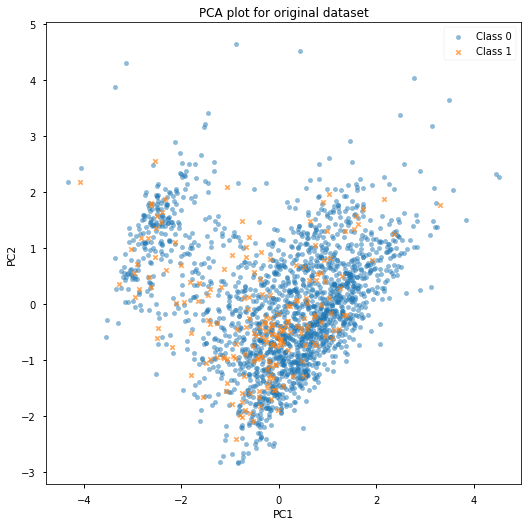

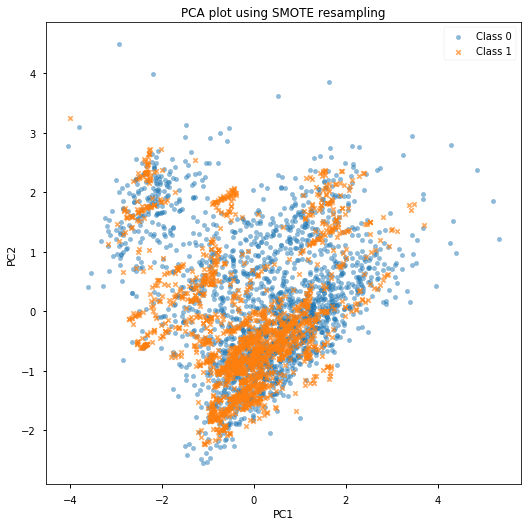

In [7]:
def pca_plot(X, y, title):
    """via https://github.com/wangz10/class_imbalance/blob/master/Main.ipynb"""
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components = 2)
    X_pc = pca.fit_transform(X)
    
    plt.style.use('seaborn-notebook')
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    mask = y==0
    ax.scatter(X_pc[mask, 0], X_pc[mask, 1], color='#1f77b4', marker='o', label='Class 0', alpha=0.5, s=20)
    ax.scatter(X_pc[~mask, 0], X_pc[~mask, 1], color='#ff7f0e', marker='x', label='Class 1', alpha=0.65, s=20)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(loc='best')
    plt.title(title);
    return

pca_plot(X_train, y_train, title='PCA plot for original dataset')
pca_plot(X_train_res, y_train_res, title='PCA plot using SMOTE resampling')

<img src="https://media.giphy.com/media/12bVDtXPOzYwda/giphy.gif" />

Um, that would be a no! A lot of goals look the same as misses, and we can see that here - there is a lot of overlap between the two classes. It's not surprising our model is struggling to achieve good results, then. We'll explore feature engineering in a future article to see if we can improve this a bit, but we probably won't get to the point where we have a clear boundary between classes.

To further illustrate why this is a particularly tricky problem, let's take a look at a different dataset where the features do a good job of differentiating between classes.

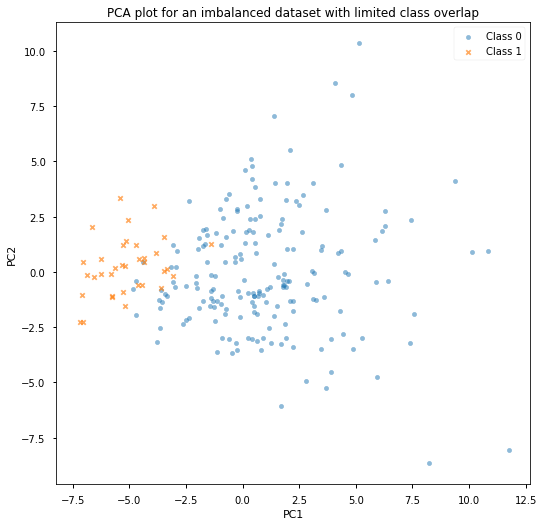

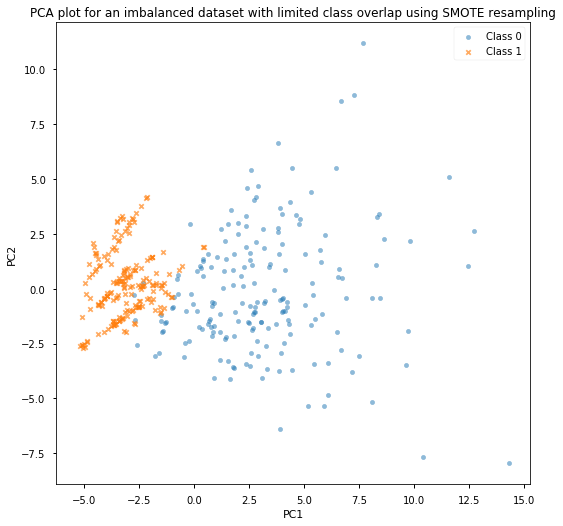

In [8]:
# Compare with a different unbalanced dataset - breast_cancer:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html
# In this case, as with many common classification problems, a clear boundary can be observed between the classes
bc_data = load_breast_cancer()

# This dataset isn't imbalanced by default
# Define function to allow resampling of the data based on a multiplier for minority class
# See https://imbalanced-learn.org/en/stable/datasets/index.html#make-imbalanced
def ratio_multiplier(y, minority_class_weight):
    multiplier = {0: minority_class_weight, 1: (1-minority_class_weight)}
    target_stats = Counter(y)
    for key, value in target_stats.items():
        target_stats[key] = int(value * multiplier[key])
    return target_stats

# Resample using a 9:1 ratio between class 0 and class 1
X_bc, y_bc = make_imbalance(bc_data.data, bc_data.target,
                            sampling_strategy=ratio_multiplier(y=bc_data.target, minority_class_weight=0.9))

# Resample again with SMOTE to compare
smote_bc = SMOTE(random_state=42, n_jobs=-1)
X_bc_res, y_bc_res = smote_bc.fit_resample(X_bc, y_bc)

# Plot results
pca_plot(X_bc, y_bc, title='PCA plot for an imbalanced dataset with limited class overlap')
pca_plot(X_bc_res, y_bc_res, title='PCA plot for an imbalanced dataset with limited class overlap using SMOTE resampling')

The dataset we are using here is __[sklearn's breast cancer data](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)__,  which is a much more typical example of the sorts of classification problems that machine learning is really well suited to. It would be pretty easy to draw a single line through these plots to separate orange and blue points, but that would be very difficult with our football data. Something like SMOTE will be really helpful here, because all of the new orange data points are still separate from the blue ones. If you have extra time, it's a great idea to play around with the breast cancer example so you can see how easy it can be to achieve really good results with machine learning.

In [ ]:
# Add some code here to train a model to predict breast cancer!
# Note that the code above plots the entire dataset
# If you want to use SMOTE, remember to split X_bc and y_bc into a training and test set first
# You will also need to have a look at the data quickly to check if there are any categorical features
# (use SMOTE-NC if there are)

## Exploring different re-sampling techniques
Our natural instinct is that more data is better, but when dealing with a lot of overlap between classes undersampling might actually be a better strategy than oversampling. The basic idea is that if we have two data points from different classes that are really close together, getting rid of one will help to define a more clear boundary between classes. Unfortunately we can already guess that this might not help us since our data is so noisy, but it's worth a try anyway! It's also possible to combine undersampling and oversampling techniques, which is often going to be a great strategy when you have a class imbalance. Let's try the following methods and see how they compare (see the links for more info):

-  __[Tomek's links undersampling](http://imbalanced-learn.org/en/stable/under_sampling.html#tomek-links)__.  If the nearest neighbour of a 'no goal' observation is a 'goal', it will be removed.
-  __[Edited nearest neighbours undersampling](http://imbalanced-learn.org/en/stable/under_sampling.html#edited-nearest-neighbors)__. Similar to Tomek's links, but it removes all 'no goal' neighbours that don't agree enough with a 'goal' observation, not just the nearest neighbour.
-  __[SMOTETomek](http://imbalanced-learn.org/en/stable/combine.html#combine)__. Carries out SMOTE re-sampling and then cleans the observations using the Tomek's links method.
-  __[SMOTEENN](http://imbalanced-learn.org/en/stable/combine.html#combine)__.  Carries out SMOTE re-sampling and then cleans the observations using the edited nearest neighbours method.

To run the tests we'll be using a random forest classifier instead of a decision tree classifier. I'll go into more detail on how random forests work in future articles. For now all you need to know is that instead of using just one decision tree, we can use an entire 'forest' that all vote on the model prediction. In practice you're always going to want to use a random forest instead of a single decision tree, as they give better results whilst also mitigating the risk of overfitting.

The following code defines functions to check a model with re-sampling using cross-validation and plot the results. Have a read through to make sure you understand how it works - if you get stuck, leave a comment. There is almost certainly a more efficient way to write this, so feel free to improve it on your own if you like.

In [9]:
# Define a function to plot barplot comparisons of models
def barplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)
    
    # Plot bars
    sns.barplot(x=x, y=y1, data=df, palette='muted', ax=axs[0])
    sns.barplot(x=x, y=y2, data=df, palette='muted', ax=axs[1])

    # Tweak the visual presentation
    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    sns.despine(trim=True, left=True);
    
    return

# Define a function to plot boxplot comparisons of models
def boxplot_comparison(df, x='name', y1='mcc', y2='brier_loss', figsize=(18, 8)):
    sns.set(style='white')

    f, axs = plt.subplots(ncols=2, figsize=figsize, sharey=False)

    # Plot boxes
    sns.boxplot(x=x, y=y1, data=df,
                whis='range', palette='muted', ax=axs[0])
    sns.boxplot(x=x, y=y2, data=df,
                whis='range', palette='muted', ax=axs[1])

    # Add in points to show each observation
    sns.swarmplot(x=x, y=y1, data=df,
                  size=4, color='.3', linewidth=0, ax=axs[0])
    sns.swarmplot(x=x, y=y2, data=df,
                  size=4, color='.3', linewidth=0, ax=axs[1])

    # Tweak the visual presentation
    axs[0].yaxis.grid(True)
    axs[0].set(xlabel="", ylim=(min(df[y1]-0.02),max(df[y1]+0.02)))
    axs[1].yaxis.grid(True)
    axs[1].set(xlabel="", ylim=(min(df[y2]-0.02),max(df[y2]+0.02)))
    #axs[1].set_ylim(axs[1].get_ylim()[::-1])
    sns.despine(trim=True, left=True);
    
    return

# Define a function to run stratified k-fold cross-validation and return scores for different models
# If resampling is set, the model will resample within each fold of the cross-validation
def check_model(model, resampling, calibrate, X=features, y=labels, cat_features=cat_cols_ind,
                k=5, print_res=True, plot_pca=False, random_state=42):
    
    # Convert inputs to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Define the cross-validation parameters
    # Common values of k are 5 and 10, as these have been shown experimentally to produce the best results
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Create lists to save results to
    mcc = []
    brier = []
    actual_goals = []
    pred_goals = []
    model_name = model.__class__.__name__

    # Create training and test data using cross validation and fit model for each fold
    for ii, (train_index, valid_index) in enumerate(cv.split(X, y)):
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if resampling == None:
            res = 'no'
        else:
            X_train, y_train = resampling.fit_resample(X_train, y_train)
            res = resampling.__class__.__name__

        # Calibrate model if necessary
        if calibrate == None:
            calibrated_probs = 'uncalibrated probabilities'
            model.fit(X_train, y_train)
        else:
            model = CalibratedClassifierCV(model, cv=2, method=calibrate)
            model.fit(X_train, y_train)
            calibrated_probs = '%s calibration' % calibrate    
            
        y_pred = model.predict(X_valid)
        y_pred_proba = model.predict_proba(X_valid)[:,1]
        
        # Calculate mcc score, brier_loss and sum of predicted goal probabilities
        actual_goals.append(sum(y_valid))
        pred_goals.append(sum(y_pred_proba))
        mcc.append(matthews_corrcoef(y_valid, y_pred))
        brier.append(brier_score_loss(y_valid, y_pred_proba))
        
        if plot_pca == True and ii == 0:
            pca_plot(X_train, y_train, title='%s with %s resampling (1st fold)'
              % (model_name, res))
        else: pass
    
    # Save the results to a dataframe
    df = pd.DataFrame()
    df['model'] = model_name
    df['resampling'] = res
    df['mcc'] = mcc
    df['brier_loss'] = brier
    df['actual_goals'] = actual_goals
    df['predicted_goals'] = pred_goals
    df['goals_diff'] = abs(df['actual_goals'] - df['predicted_goals'])
    df['calibrated'] = calibrated_probs
    
    # Print a summary of the results if required
    if print_res == True:
        print('Method: %s with %s resampling and %s'
              % (model_name, res, calibrated_probs))
        print('Goals:', '{0:.2f}'.format(df['actual_goals'].mean()))
        print('Predicted Goals:', '{0:.2f}'.format(df['predicted_goals'].mean()))
        print('MCC:', '{0:.3f}'.format(df['mcc'].mean()))
        print('Brier Loss:', '{0:.3f}'.format(df['brier_loss'].mean()))
        print('')
    else: pass

    return df

Now that's done, we can add models to a list and loop through it, calling check_model to test each model in turn.

Method: RandomForestClassifier with no resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 49.51
MCC: 0.177
Brier Loss: 0.080

Method: RandomForestClassifier with SMOTENC resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 89.98
MCC: 0.241
Brier Loss: 0.102

Method: RandomForestClassifier with TomekLinks resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 54.17
MCC: 0.198
Brier Loss: 0.081

Method: RandomForestClassifier with EditedNearestNeighbours resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 77.30
MCC: 0.213
Brier Loss: 0.092

Method: RandomForestClassifier with SMOTETomek resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 83.29
MCC: 0.243
Brier Loss: 0.100

Method: RandomForestClassifier with SMOTEENN resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 67.99
MCC: 0.215
Brier Loss: 0.095



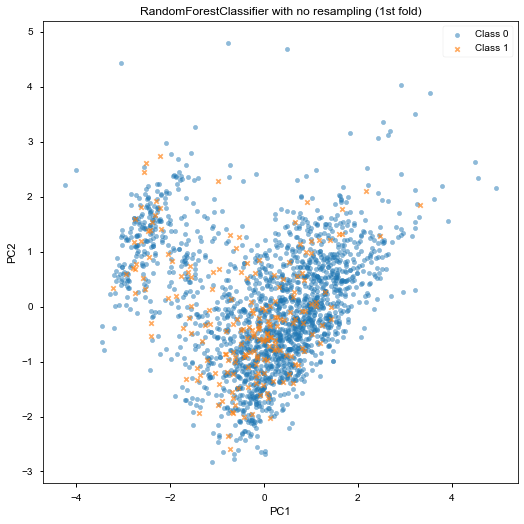

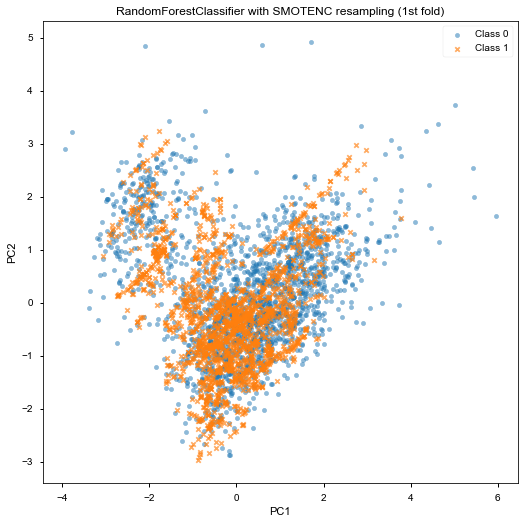

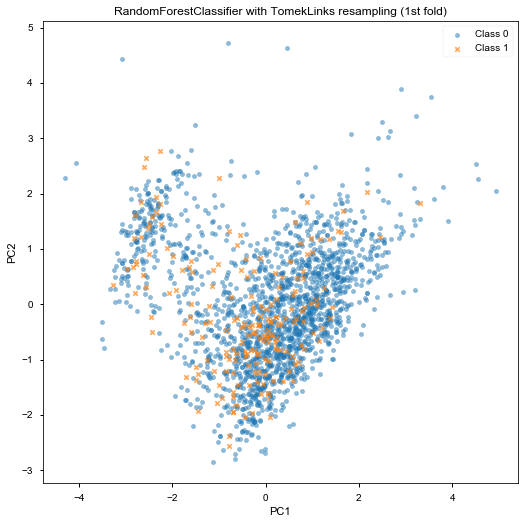

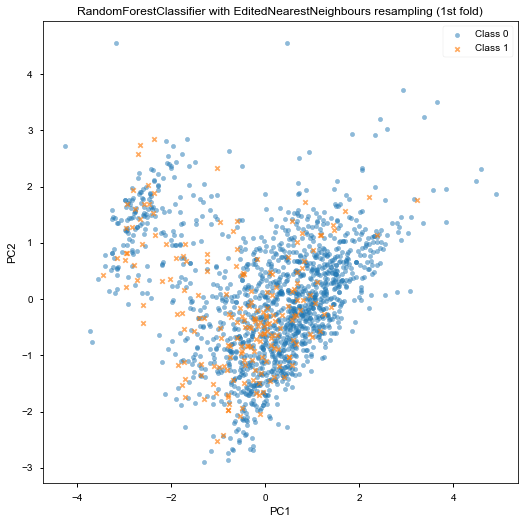

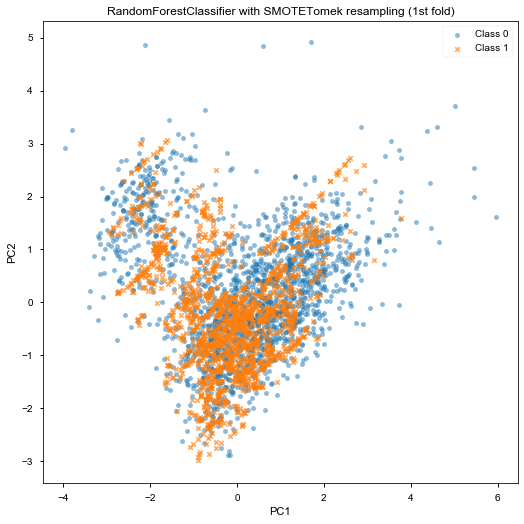

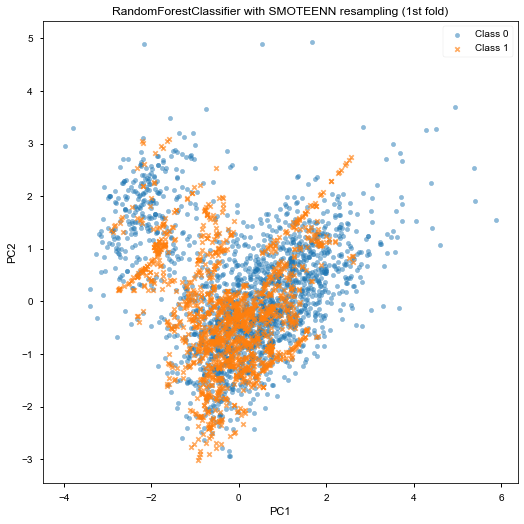

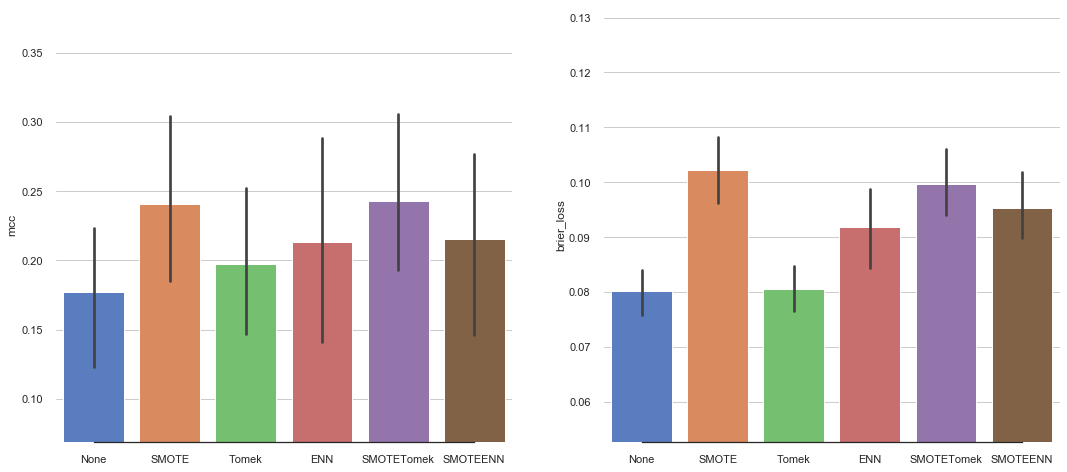

In [11]:
# Try different re-sampling methods with a RandomForestClassifier
# For some reason sklearn and imblearn's default is to use only one processor core
# Most people have multiple cores these days!
# n_jobs=-1 will run the model on all cores in parallel, which can speed things up quite a bit

tomek = TomekLinks(n_jobs=-1, random_state=42)
enn = EditedNearestNeighbours(n_jobs=-1, random_state=42)
smote_tomek = SMOTETomek(smote=smote, tomek=tomek, random_state=42)
smote_enn = SMOTEENN(smote=smote, enn=enn, random_state=42)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

models = []
# Format is name, model, resampling method, probability calibration
models.append(('None', rf, None, None))
models.append(('SMOTE', rf, smote, None))
models.append(('Tomek', rf, tomek, None))
models.append(('ENN', rf, enn, None))
models.append(('SMOTETomek', rf, smote_tomek, None))
models.append(('SMOTEENN', rf, smote_enn, None))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate, plot_pca=True)
    result['name'] = name
    results_df = results_df.append(result)

# Call boxplot_comparison here instead if you like
barplot_comparison(results_df)

The first thing you will notice is that we are evaluating the models based on two metrics we haven't come across yet - 'mcc' and 'brier_loss'.

-  __[Matthews correlation coefficient (MCC)](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)__. One of the better ways to represent an entire confusion matrix in a single number (see link for details). Values range from -1 (horrible) to +1 (perfect), with zero being no better than random.
-  __[Brier loss score](https://en.wikipedia.org/wiki/Brier_score)__. This gives us a single number to help determine how accurate the model is at predicting the probability of an observation belonging to each class. This metric measures the mean squared difference between the predicted probabilities and the actual outcome, so a lower value is better.

Given our domain expertise, and what we have just observed about the distribution of our data, we know already that trying to accurately classify 'goal' and 'no goal' in a pure sense is probably a lost cause. Instead, it makes sense to focus on the ability of our model to predict the probability of 'goal' or 'no goal', since this is what we actually care about with an xG model anyway. Random forests typically average out the predictions from each tree to produce probability estimates, so __[they often outperform logistic regression models](https://stats.stackexchange.com/questions/337250/random-forest-probability-vs-logistic-regression-probability)__. In fact, random forests (or some variation of them) are so good that they are pretty much the only thing you need to use in practice unless you're doing deep learning!

We can see here that unfortunately there seems to be a trade-off between the Matthews correlation coefficient and Brier score, with the exception of Tomek's links re-sampling. If you're following along in notebook form you will notice that the re-sampling methods tend to produce probability estimates that are far too high, e.g. 92.8 predicted goals with SMOTE vs 49 actual goals! This is because the balanced training data now looks very different to the imbalanced test data. If our goal is to optimise for Brier score loss instead of MCC, maybe we don't want to use re-sampling after all.

## Calibrating probabilities
In sklearn, it's possible to 'calibrate' the probability estimates of a classifier, which can sometimes result in a lower Brier loss (see __[here](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)__ and __[here](http://jmetzen.github.io/2015-04-14/calibration.html)__ for more detailed explanations). The following code can be used to plot reliability curves using no calibration, __[Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling)__ (sigmoid) and __[isotonic regression](https://en.wikipedia.org/wiki/Isotonic_regression)__. In my opinion this is one of those situations where you don't need to worry too much about learning exactly how something works, just try it out and see if it helps!

RF:
Goals: 49
Predicted Goals: 49.73
MCC: 0.125
Brier Loss: 0.086

RF + Isotonic:
Goals: 49
Predicted Goals: 48.47
MCC: 0.062
Brier Loss: 0.081

RF + Sigmoid:
Goals: 49
Predicted Goals: 47.87
MCC: 0.122
Brier Loss: 0.083



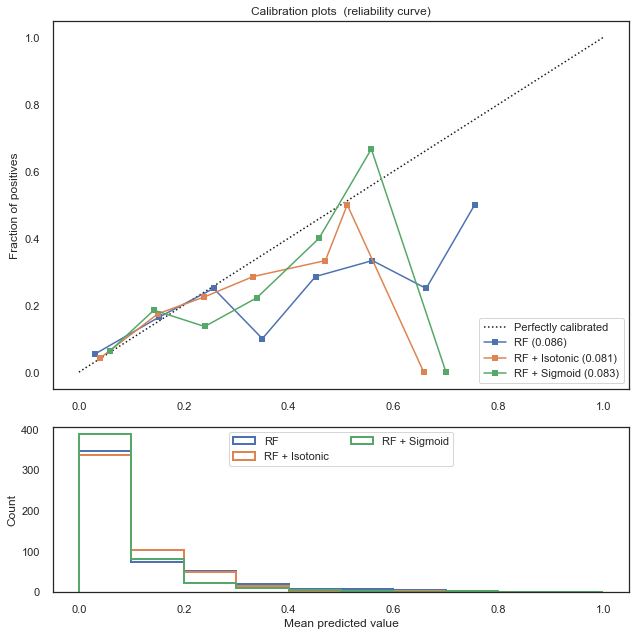

In [13]:
def plot_calibration_curve(name, model, cv, resampling=None,
                           X_train=X_train, y_train=y_train,
                           X_test=X_test, y_test=y_test):
    """Plot calibration curve for est w/o and with calibration
    see http://jmetzen.github.io/2015-04-14/calibration.html
    """   
    # Resampling
    if resampling == None:
        pass
    else:
        X_train, y_train = resampling.fit_resample(X_train, y_train) 
       
    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(model, cv=cv, method='sigmoid')
    
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(model, cv=cv, method='isotonic')

    # Fit and plot each model
    fig = plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(model, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        clf_score = brier_score_loss(y_test, y_pred_proba, pos_label=labels.max())
        
        print("%s:" % name)
        print('Goals:', (sum(y_test)))
        print('Predicted Goals:', '{0:.2f}'.format((sum(y_pred_proba))))
        print('MCC:', '{0:.3f}'.format(matthews_corrcoef(y_test, y_pred)))
        print('Brier Loss:', '{0:.3f}'.format(clf_score))
        print('')

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_pred_proba, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(y_pred_proba, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    
plot_calibration_curve("RF", model=rf, cv = 5, resampling=None)

Values underneath the diagonal mean that the probability estimates tend to be too high, which is the case with our default random forest (blue). Calibration does appear to improve things a bit, with the orange and green lines following the diagonal more closely, so it might be worth using in our model. __[Isotonic regression has been shown to overfit on small datasets](https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/)__, so to be safe Platt scaling is a better choice in our case. Let's see if it helps our random forest when using re-sampling.

Method: RandomForestClassifier with no resampling and sigmoid calibration
Goals: 49.00
Predicted Goals: 49.43
MCC: 0.106
Brier Loss: 0.081

Method: RandomForestClassifier with SMOTENC resampling and sigmoid calibration
Goals: 49.00
Predicted Goals: 105.80
MCC: 0.256
Brier Loss: 0.123

Method: RandomForestClassifier with TomekLinks resampling and sigmoid calibration
Goals: 49.00
Predicted Goals: 53.03
MCC: 0.127
Brier Loss: 0.080

Method: RandomForestClassifier with EditedNearestNeighbours resampling and sigmoid calibration
Goals: 49.00
Predicted Goals: 73.23
MCC: 0.216
Brier Loss: 0.087

Method: RandomForestClassifier with SMOTETomek resampling and sigmoid calibration
Goals: 49.00
Predicted Goals: 98.09
MCC: 0.257
Brier Loss: 0.120

Method: RandomForestClassifier with SMOTEENN resampling and sigmoid calibration
Goals: 49.00
Predicted Goals: 82.78
MCC: 0.251
Brier Loss: 0.114



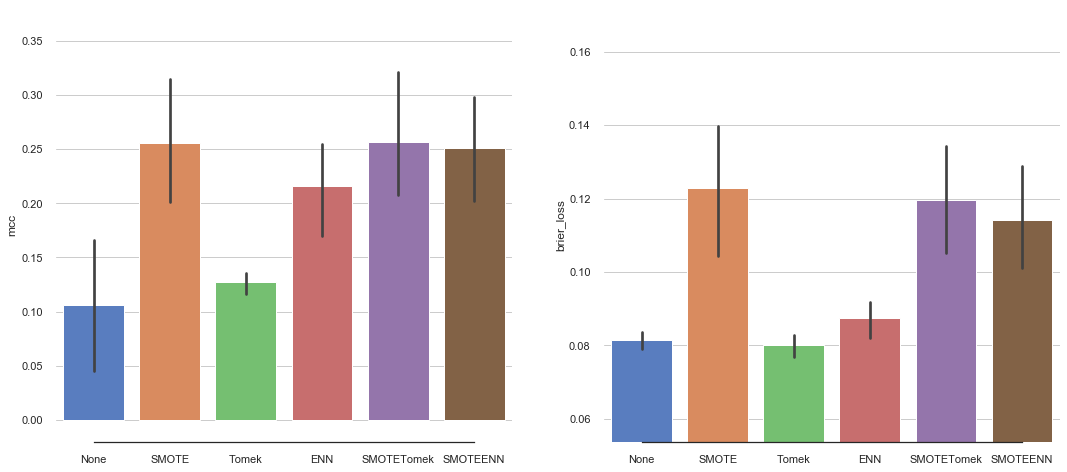

In [14]:
models = []
models.append(('None', rf, None, 'sigmoid'))
models.append(('SMOTE', rf, smote, 'sigmoid'))
models.append(('Tomek', rf, tomek, 'sigmoid'))
models.append(('ENN', rf, enn, 'sigmoid'))
models.append(('SMOTETomek', rf, smote_tomek, 'sigmoid'))
models.append(('SMOTEENN', rf, smote_enn, 'sigmoid'))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate)
    result['name'] = name
    results_df = results_df.append(result)
    
barplot_comparison(results_df)

We know from the reliability curves that calibration does help a little, but the Brier loss is still far too high with most re-sampling techniques aside from Tomek's links. If we use any of these methods in our final model it should be Tomek's links with sigmoid calibration, otherwise it's probably best to just ignore re-sampling altogether.

## Testing different algorithms
In __[the previous article](http://www.fantasyfutopia.com/python-for-fantasy-football-addressing-class-imbalance-in-machine-learning/)__ I mentioned that specialised machine learning algorithms exist that help deal with class imbalance. These algorithms typically include class weighting and/or some form of re-sampling by default. Unsurprisingly, there are a couple of algorithms built into imblearn that we can try. We will test the performance of the following:

-  Sklearn's __[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)__
-  Imblearn's __[BalancedRandomForestClassifier](http://imbalanced-learn.org/en/stable/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier)__
-  Sklearn's __[AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)__
-  Imblearn's __[EasyEnsembleClassifier](http://imbalanced-learn.org/en/stable/generated/imblearn.ensemble.EasyEnsembleClassifier.html#imblearn.ensemble.EasyEnsembleClassifier)__, which also uses AdaBoost (Adaptive Boosting) learners
-  __[XGBoost](https://xgboost.readthedocs.io/en/latest/)__, an 'eXtreme Gradient Boosting' algorithm that often achieves superior performance to other techniques

I'll look at a couple of these algorithms more in the next article, but if you want to skip ahead a bit click the links above to read through the documentation for each.

Method: RandomForestClassifier with no resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 49.51
MCC: 0.177
Brier Loss: 0.080

Method: BalancedRandomForestClassifier with no resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 205.19
MCC: 0.294
Brier Loss: 0.186

Method: AdaBoostClassifier with no resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 246.63
MCC: 0.186
Brier Loss: 0.237

Method: EasyEnsembleClassifier with no resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 249.27
MCC: 0.303
Brier Loss: 0.240

Method: XGBClassifier with no resampling and uncalibrated probabilities
Goals: 49.00
Predicted Goals: 47.98
MCC: 0.143
Brier Loss: 0.076



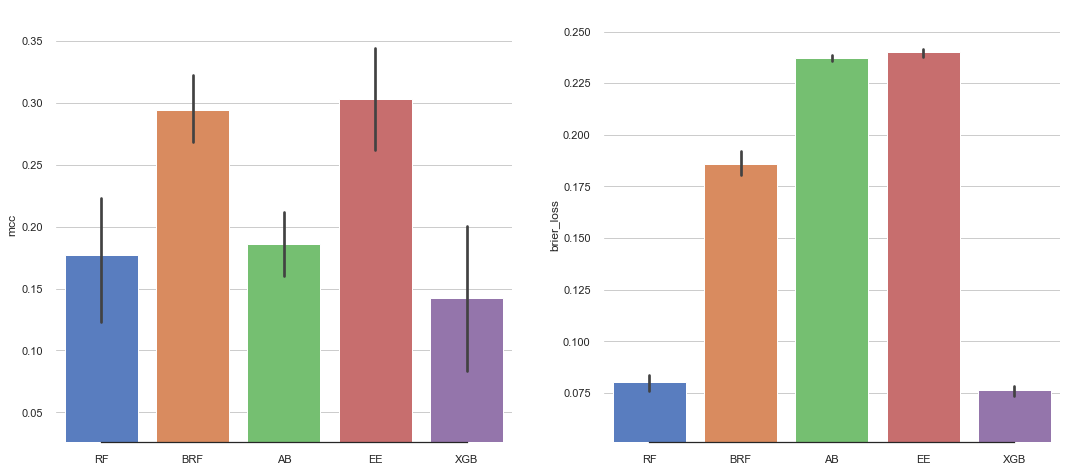

In [15]:
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
ab = AdaBoostClassifier(n_estimators=100, random_state=42)
ee = EasyEnsembleClassifier(n_estimators=100, random_state=42, n_jobs=-1)
xgb = XGBClassifier(random_state=42)

models = []
models.append(('RF', rf, None, None))
models.append(('BRF', brf, None, None))
models.append(('AB', ab, None, None))
models.append(('EE', ee, None, None)) # takes forever to run with calibration, be careful!
models.append(('XGB', xgb, None, None))

results_df = pd.DataFrame()
for name, model, resampling, calibrate in models:
    result = check_model(model, resampling, calibrate)
    result['name'] = name
    results_df = results_df.append(result)
    
barplot_comparison(results_df)

It's not really fair to compare the imblearn algorithms (using re-sampling) to the default random forest or XGBoost classifier (try and use re-sampling in those as well if you like), but what this analysis does tell us is that their probability estimates will be nowhere near what we'd like to see. Calibration does improve the loss significantly for BRF and EE, although it takes a really long time to run and the results are no better than the other algorithms anyway. AdaBoost also looks pretty terrible all around in comparison to the rest, so we'll definitely ignore that going forward. What we have basically seen here is what experienced practitioners would tell you from the start - random forests and XGBoost are all you should be using in pretty much every situation. For that reason, I'll dive into these two in more depth in the next part of the series.

## Conclusion
We've seen here that understanding how to attack a problem with machine learning isn't always as simple as it first appears. After thinking we were onto a winner with SMOTE, it looks like we should instead use Tomek's links undersampling, or just avoid re-sampling altogether. Hopefully you aren't put off yet, as this is a particularly frustrating example to look at for an introductory series (sorry!). I strongly encourage trying out some other classification problems, e.g. the breast cancer one above, to get a better idea of how easy it can be to create good machine learning models. Sklearn has a lot of built-in datasets that you can use - just chuck the data into a random forest and see what happens!

As always, thanks for reading! Please share the article on social media if you found it useful. The next part is already in the works, so it shouldn't be long before it's released! Thanks to __[StatsBomb](https://statsbomb.com/)__ for providing the data.